# Nama : Aini Nur Khasanah
# NIM  : 19.11.2595
# Kelas : 19-IF01
# Mata Kuliah : Data Mining
# Dosen Pengampu : Mardhiya Hayaty, S.T, M.Kom 
# UJIAN AKHIR SEMESTER!
# Mendeteksi Fake News Dengan Menggunakan Recurrent Neural Network kombinasi Bidirectional LSTM

# **Data Collection**

In [ ]:
# mount / menyambungkan ke drive, karena datasetnya saya letakkan didrive
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# Mengimport Library
import numpy as np # linear algebra
import pandas as pd # struktur data, alat statistik, dan data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt # membuat plot dan grafik 2D

READ DATA

In [ ]:
#Mengimport Dataset menggunakan pandas
true_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UAS_2595_Mining/backup/True.csv")
fake_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UAS_2595_Mining/backup/Fake.csv")

Menampilkan datanya

In [ ]:
# menampilkan data true news teratas
true_news.head()

In [ ]:
# menampilkan data fake news teratas
fake_news.head()

# **Data Cleaning**

In [ ]:
# menampilkan bentuk data, jumlah baris dan kolom
true_news.shape

In [ ]:
# menampilkan bentuk data, jumlah baris dan kolom
fake_news.shape

In [ ]:
# mengecek nilai true news yang hilang
true_news.apply(lambda x: sum(x.isnull()))

In [ ]:
# mengecek nilai fake news yang hilang
fake_news.apply(lambda x: sum(x.isnull()))

Set nilai

In [ ]:
# mengeset antara true dan fake
fake_news['kelas'] = 0 
true_news['kelas'] = 1

In [ ]:
# menghilangkan field date dan subject, karena yang dibutuhkan disini hanya title dan text
fake_news.drop(['date', 'subject'], axis=1, inplace=True)
true_news.drop(['date', 'subject'], axis=1, inplace=True)

In [ ]:
# fungsi concat ini untuk menggabungkan dataset, contoh kasus disini ada 2 dataset. Dengan parameter axis 0
semua_data = pd.concat([true_news,fake_news],axis=0)

In [ ]:
semua_data = semua_data.sample(frac=1).reset_index(drop=True)
semua_data

,title,text,kelas
0,OUCH! CHUCK TODD HUMILIATES DNC Chair Over Sic...,It s hard to shame someone when they have no s...,0
1,Highlights: The Trump presidency on February 1...,(Reuters) - Highlights of the day for U.S. Pre...,1
2,"Factbox: Trump to meet with Oklahoma governor,...",(Reuters) - U.S. Republican President-elect Do...,1
3,South African Supreme Court upholds reinstatin...,"BLOEMFONTEIN, South Africa (Reuters) - South A...",1
4,Leave It To Obama To ROAST Trump For Saying H...,"If you haven t noticed, Donald Trump isn t qui...",0
...,...,...,...
44893,Bette Midler Weighs In On #CruzSexScandal And...,Bette Midler has made her distaste for the GOP...,0
44894,UPDATE: BUSTED By The Secret Service…CNN’s Apr...,The Secret Service pushed back on a CNN report...,0
44895,Trump signs resolution allowing U.S. states to...,WASHINGTON (Reuters) - President Donald Trump ...,1
44896,OBAMA’S REVEALING LETTER TO BROTHER TELLS WHY ...,"Well, it s not like we didn t know this but it...",0


In [ ]:
semua_data.title[1]

'Highlights: The Trump presidency on February 1 at 7:44 P.M. EST/1244 GMT'

In [ ]:
semua_data.text[1]

'(Reuters) - Highlights of the day for U.S. President Donald Trump’s administration on Wednesday: Trump urges Senate Republicans to “go nuclear” and impose a rule change to force a simple majority vote toward confirmation if Democrats block his U.S. Supreme Court nominee. Public refusals by two U.S. Senate Republicans to support Betsy DeVos, Trump’s pick for education secretary, raise the possibility of a rare congressional rejection of a Cabinet nominee. The Senate confirms Rex Tillerson as secretary of state despite concerns over his ties to Russia, while committees approve Jeff Sessions, one of Trump’s most controversial Cabinet selections, as attorney general, as well as two other nominees. Evangelical Christian leader Jerry Falwell Jr. will head an education reform task force under Trump and is eager to cut university regulations, including rules on dealing with campus sexual assault. The White House puts Iran “on notice” for test-firing a ballistic missile and says it is reviewin

In [ ]:
semua_data.head()

,title,text,kelas
0,OUCH! CHUCK TODD HUMILIATES DNC Chair Over Sic...,It s hard to shame someone when they have no s...,0
1,Highlights: The Trump presidency on February 1...,(Reuters) - Highlights of the day for U.S. Pre...,1
2,"Factbox: Trump to meet with Oklahoma governor,...",(Reuters) - U.S. Republican President-elect Do...,1
3,South African Supreme Court upholds reinstatin...,"BLOEMFONTEIN, South Africa (Reuters) - South A...",1
4,Leave It To Obama To ROAST Trump For Saying H...,"If you haven t noticed, Donald Trump isn t qui...",0


In [ ]:
semua_data.tail()

,title,text,kelas
44893,Bette Midler Weighs In On #CruzSexScandal And...,Bette Midler has made her distaste for the GOP...,0
44894,UPDATE: BUSTED By The Secret Service…CNN’s Apr...,The Secret Service pushed back on a CNN report...,0
44895,Trump signs resolution allowing U.S. states to...,WASHINGTON (Reuters) - President Donald Trump ...,1
44896,OBAMA’S REVEALING LETTER TO BROTHER TELLS WHY ...,"Well, it s not like we didn t know this but it...",0
44897,First Somali Refugee Elected In American Hist...,"On November 8, 2016, Ilhan Omar made history a...",0


In [ ]:
# mengkombinasikan kolom title dan text menjadi 1 kolom dengan nama text
semua_data['text'] = semua_data['title'] + semua_data['text']
semua_data.drop('title', axis=1, inplace=True)

In [ ]:
semua_data.head()

,text,kelas
0,OUCH! CHUCK TODD HUMILIATES DNC Chair Over Sic...,0
1,Highlights: The Trump presidency on February 1...,1
2,"Factbox: Trump to meet with Oklahoma governor,...",1
3,South African Supreme Court upholds reinstatin...,1
4,Leave It To Obama To ROAST Trump For Saying H...,0


**Menemukan Fake News Berdasarkan Judul Dan Text**

Processing data

In [ ]:
x_data = semua_data.text[:10000]
y_data = semua_data.kelas[:10000]

In [ ]:

num_words = 10000
max_len= 500

In [ ]:
# membuat objek tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words+1)
# melatih tokenizer untuk teks
tokenizer.fit_on_texts(x_data)
# convert list string ke list bilangan bulat
sequences_x_data = tokenizer.texts_to_sequences(x_data)
padded_x_data = tf.keras.preprocessing.sequence.pad_sequences(sequences_x_data, maxlen=500, padding="post", truncating="post")

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(padded_x_data,np.array(y_data),test_size=0.2)

Modeling

In [ ]:
# Embedding layer
model_data = keras.Sequential([keras.layers.Embedding(num_words+1,16,input_length=max_len),
                               keras.layers.Bidirectional(keras.layers.LSTM(64)), # membuat LSTM bidirectional
                               keras.layers.Dense(16,activation="relu"), # FC layer untuk bagian klasifikasi
                               keras.layers.Dense(1,activation="sigmoid")
                               ])

In [ ]:
model_data.compile(loss="binary_crossentropy",metrics=["accuracy"],optimizer="adam")

In [ ]:
history_semua_data = model_data.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
250/250 [==============================] - 105s 405ms/step - loss: 0.2530 - accuracy: 0.9179 - val_loss: 0.0302 - val_accuracy: 0.9930
Epoch 2/10
250/250 [==============================] - 101s 404ms/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.0137 - val_accuracy: 0.9945
Epoch 3/10
250/250 [==============================] - 102s 407ms/step - loss: 5.7401e-04 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 0.9955
Epoch 4/10
250/250 [==============================] - 102s 407ms/step - loss: 1.6661e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9955
Epoch 5/10
250/250 [==============================] - 101s 405ms/step - loss: 8.6600e-05 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9950
Epoch 6/10
250/250 [==============================] - 101s 402ms/step - loss: 5.0750e-05 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9945
Epoch 7/10
250/250 [==============================] - 102s 409ms/step - loss: 3.3611e-05 - accuracy: 1.0000 

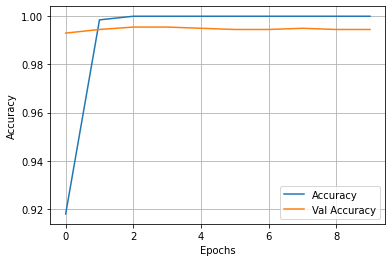

In [ ]:
history_semua = pd.DataFrame(history_semua_data.history)
plt.plot(history_semua.accuracy,label="Accuracy")
plt.plot(history_semua.val_accuracy,label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

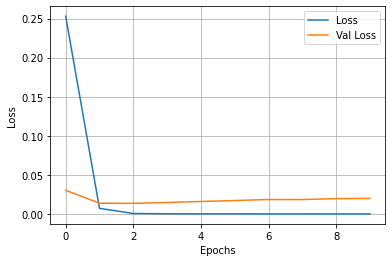

In [ ]:
plt.plot(history_semua.loss,label="Loss")
plt.plot(history_semua.val_loss,label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

Klasifikasi

In [ ]:
def prediksi_judul(sentence,model):
    sentence_seq = tokenizer.texts_to_sequences(sentence)
    sentence_pad = keras.preprocessing.sequence.pad_sequences(sentence_seq,maxlen=max_len, padding="post", truncating="post")
    prediksi = model.predict(sentence_pad)
    # jika prediksi berita true lebih dari 0.5 maka muncul 1, jika kurang dari 0.5 muncul 0
    if prediksi > 0.5:
        predict = 1
    else:
        predict = 0
    return predict

In [ ]:
# kondisi : berita sepenuhnya true
prediksi_judul(["Singapore sees running autonomous buses on public roads from 2022.SINGAPORE (Reuters) - Singapore is hoping to deploy autonomous buses on public roads in three different districts of the city-state from 2022 to provide better connectivity, the country"],model_data)

1

In [ ]:
# kondisi : berita sepenuhnya fake
prediksi_judul(["Heiress To Disney Empire Knows GOP Scammed Us – SHREDS Them For Tax Bill. Abigail Disney is an heiress with brass ovaries who will profit from the GOP tax scam bill"],model_data)

0

In [ ]:
# kondisi : true news kurang dari 0.5 atau 70% fake 30% true atau tercampur dengan berita fake
prediksi_judul(["Singapore sees running autonomous buses on public roads. Abigail Disney is an heiress with brass ovaries who will profit from the GOP tax scam bill but isn t into f-cking poor people over."],model_data) # Cek data salah maka hasilnya 1

0

In [ ]:
# kondisi : true news lebih dari 0.5 atau 70% true 30% fake atau tercampur berita fake
prediksi_judul(["Singapore sees running autonomous buses on public roads from 2022.SINGAPORE (Reuters) - Singapore is hoping to deploy autonomous. Heiress To Disney"],model_data) # Cek data salah maka hasilnya 1

1